In [64]:
import numpy as np
import scipy as sp
import pandas as pd
from os import listdir
import shutil
import seaborn as sb
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import colors
from sklearn.manifold import TSNE
import subprocess
import shlex
import scanpy
from sklearn.metrics import r2_score
import random

# todo:
# umap / tsne on the whole dataset to see if ages are naturally seperable


Aging is the time dependant weaking of the body. For example, aging in the pancreous can predispose people to diabetes (https://www.imrpress.com/journal/FBE/10/1/10.2741/e813). I will attempt to find theraputic targets that could be used to target aging in the pancreatus using scRNA-Seq data from  https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE81547.

A good target is a gene or pathway that:

(1) Has reletively constant expression accross cells from the same individual. Targeted cell delivery is a hard process, especially between cell types in the same organ, so the genes or pathways need to be consistant accross the single cells.

(2) Is highly corralative with age. This is less important because if there is a gene whose expression is dependant on age in some nonlinear maner, it could still be a good target if it is modulated carefully. This is a simplifying assumption.

(3) Has a large magnatude of change with age. Something that only changes subtley with age will be harder to modulate. This is more for gene selection rather than pathway selection.

# Data Preprocessing

Creates the aggragated data for each sample in the ClupedData folder

This just puts the data in a nicer form for downstream processing: files named with the donor age and sex with the counts of each RNA in each row.

This is the description of the data:

	As organisms age, cells accumulate genetic and epigenetic changes that eventually lead to impaired organ function or catastrophic failure such as cancer. Here we describe a single-cell transcriptome analysis of 2544 human pancreas cells from donors, spanning six decades of life. We find that islet cells from older donors have increased levels of disorder as measured both by noise in the transcriptome and by the number of cells which display inappropriate hormone expression, revealing a transcriptional instability associated with aging. By analyzing the spectrum of somatic mutations in single cells from previously-healthy donors, we find a specific age-dependent mutational signature characterized by C to A and C to G transversions, indicators of oxidative stress, which is absent in single cells from human brain tissue or in a tumor cell line. Cells carrying a high load of such mutations also express higher levels of stress and senescence markers, including FOS, JUN, and the cytoplasmic superoxide dismutase SOD1, markers previously linked to pancreatic diseases with substantial age-dependent risk, such as type 2 diabetes mellitus and adenocarcinoma. Thus, our single-cell approach unveils gene expression changes and somatic mutations acquired in aging human tissue, and identifies molecular pathways induced by these genetic changes that could influence human disease. Also, our results demonstrate the feasibility of using single-cell RNA-seq data from primary cells to derive meaningful insights into the genetic processes that operate on aging human tissue and to determine which molecular mechanisms are coordinated with these processes.

This dataset contains scRNA-seq data on the pancreas of humans of various ages.

In [65]:
path = 'GSE81547'
datasets = sorted([path+'/'+i for i in listdir(path)])

pd.read_csv(datasets[0],delimiter='\t',header=None)

,0,1
0,1/2-SBSRNA4,0
1,A1BG,0
2,A1BG-AS1,0
3,A1CF,0
4,A2LD1,0
...,...,...
23460,no_feature,407558
23461,ambiguous,3754
23462,too_low_aQual,0
23463,not_aligned,0


The files themselves don't contain any information on the samples. Clumn 0 contains the gene and column 1 contains the Transcript counts. The last 5 rows contains data on the RNA-Seq preprocessing. First lets use the metadata file to get the ages and sexes of each sample.

In [66]:
id2file = lambda id: [i for i in datasets if i[i.find('/')+1:i.find('_')] == id][0]
with open('GSE81547_series_matrix.txt') as f:
    for line in f:
        if line.startswith('!Series_sample_id'):
            identifier = line[len('!Series_sample_id\t')+1:-3].split(' ')
        if line.startswith('!Sample_title'):
            donor = [(int(i[1:i.find('yr')]),i[i.find('_')+1]) for i in line[len('!Sample_title\t'):].split('\t')]
            donor = [(i, [id2file(identifier[j]) for j,k in enumerate(donor) if k == i]) for i in set(donor)]
donor.sort()

In [67]:
for id,files in donor:
    dfs = [pd.read_csv(files[0],delimiter='\t',header=None)] + [pd.read_csv(f,delimiter='\t',header=None)[1] for f in files[1:]]
    totdata = pd.concat(dfs,axis=1).iloc[:-5, :]
    totdata.columns = ['Gene'] + list(range(len(totdata.columns)-1))
    totdata.to_csv(f'ClumpedData/{"0"*(id[0]<10)}{id[0]}_{id[1]}.csv',index=False,sep='\t')

Now we have a function that takes the file name and returns the metadata

# Data Cleaning

I will be using enhance from https://www.biorxiv.org/content/10.1101/655365v2.full

The algorithm is incredibly simple. It basically assumes the data has a large nullspace and the data is noisy and uses PCA to choose which dimensions to keep.

One potentially bad assumption that this makes is that the low dimentional space that biological expression data falls can be represented as the linear combination of basis vectors, rather than being on an arbetrary manifold. This would lead to the PCA either losing some biological signal because it removed too many dimentions are retaining some technical noise because it used more PCA dimentions than the dimention of the manifold so that it could actually retain the whole manifold as a subspace.

In [68]:
folder = 'ClumpedData/'
for file in listdir(folder):
    subprocess.call(shlex.split(f'python3 enhance/enhance.py -f {folder+file} -o DenoisedData/{file} --seed 0'))

[2022-02-26 12:36:39] INFO: Reading the expression matrix (24.4 MB) from "ClumpedData/38_f.csv"...
[2022-02-26 12:36:40] INFO: The expression matrix contains 23460 genes and 474 cells.
[2022-02-26 12:36:40] INFO: Applying ENHANCE...
[2022-02-26 12:36:40] INFO: Input matrix hash: 6252997962fecec3c3afc6b35e100870
[2022-02-26 12:36:41] INFO: The median transcript count of the matrix is 559682.5.
[2022-02-26 12:36:41] INFO: Will perform denoising with k=1 (value was determined automatically based on a target transcript count of 200000).
[2022-02-26 12:36:41] INFO: Determining the number of significant PCs...
[2022-02-26 12:36:45] INFO: The number of significant PCs is 50.
[2022-02-26 12:36:45] INFO: Aggregating cells...
[2022-02-26 12:36:48] INFO: Removing noise using PCA...
[2022-02-26 12:36:50] INFO: ENHANCE took 9.2 s.
[2022-02-26 12:36:50] INFO: Denoised matrix hash: 2cf78b970ff28bbad9f01b66224177b8
[2022-02-26 12:36:50] INFO: Writing the denoised expression matrix to "DenoisedData/38_

Now that the data is (hopefully) denoised, I can store the data in some variables for downstreme analysis.

In [156]:
folder = 'DenoisedData/'
iqrs = []
meds = []
for i,f in enumerate(sorted(listdir(folder))):
    df = pd.read_csv(folder+f,delimiter='\t')
    counts = df[df.columns[1:]]
    genes = df['Gene']
    # print('(Genes, Cells) =',counts.shape)
    genemed = np.median(counts,axis=1)
    geneiqr = np.percentile(counts, [75 ,25],axis=1)

    iqrs += [geneiqr]
    meds += [genemed]
iqrs = np.array(list(iqrs))
meds = np.array(list(meds))
gene2ind = { j : i for i,j in enumerate(genes) }

# Reactome Pathway Analysis

Aging has many causes, so targeting any specific gene will likely not result in a succesful drug. I will see which pathways are differentially regulated due to age so they could be used as a drug target. The idea is if, for example, immune system pathways are enriched, immunosuprescence could be a potential drug target.


I will be using Reactome for my pathway analysis. For pathway analysis, noise matters less because false posatives aren't that big of a deal. In order to find the biologically meaningful genes while allowing nonlinear relationships in the data, I will be using parabolic regression. I can't check for any complicated nonlinear relationships because I only have 8 samples.

In [148]:
t = [int(i[:2]) for i in sorted(listdir(folder))]
goodinds = []
for i,y in enumerate(meds.T):
    if np.max(y) > 1:
        poly = np.poly1d(np.polyfit(t, y, 2))
        yhat = poly(t)
        r = r2_score(y,yhat)
        if r > 0.7:
            goodinds += [i]


print('Reactome genes with a good parabolic fit:',len(goodinds))
with open('ReactomeGenesV0.txt','w+') as f:
    for i in genes[goodinds]:
        f.write(i+'\n')

Reactome genes with a good parabolic fit: 382


Let's check out some of these genes to make sure they're actually related to age... (Just run the cell over and over for different examples)

Text(0, 0.5, 'Gene Expression')

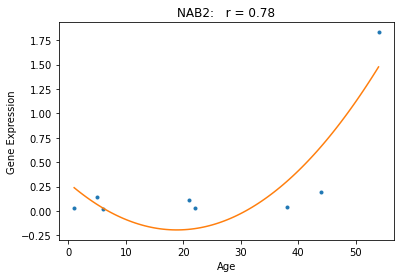

In [151]:
thay = np.linspace(min(t),max(t),100)
g = random.choice(goodinds)
y = meds[:,g].T
poly = np.poly1d(np.polyfit(t, y, 2))
yhat = poly(t)
r = r2_score(y,yhat)
plt.plot(t,y,'.')
plt.plot(thay,poly(thay))
plt.title(f"{genes[g]}:   r = {round(r,2)}")
plt.xlabel('Age')
plt.ylabel('Gene Expression')

These genes were then ran through Reactome for pathway analysis.

Section 4 shows the most upregulated pathways. There's plenty of pathways for a biologist to interperate. The most important thing to look at is the False Discovery Rate (FDR). It can be thought of as the probability that the pathway is differentially expressed through chance alone, as opposed to through biologically relevent meanings.

For a visual interprotation, see the image below.

The more yellow a pathway is, the more confident Reactome is that relates to aging.

![alt text](ReacfoamV0.jpg "PathwaysV0")

# Overlap

This section will look for the subset of genes that are enriched in multiple pathways that we could actually target with the theraputic

In [152]:
data = pd.read_csv('ReactomeDataV0.csv')

gene2path = { i : [] for i in genes}
for i , j , fdr in zip(data['Submitted entities found'],data['Pathway name'],data['Entities FDR']):
    if fdr < 0.05:
        for k in i.strip().split(';'):
            if k in gene2path:
                gene2path[k] += [j]

gene2path is a dictionary mapping the genes to age with the pathways they're involved in. Let's use this to find the genes that are most associated with the enriched pathways.

We'll start by eliminating genes that have 1 or less significant pathways.

In [153]:
possibletargets = { i : j for i,j in gene2path.items() if len(j) > 1 }
possibletargets

{'CAMK2G': ['Transcriptional Regulation by MECP2',
  'Regulation of MECP2 expression and activity'],
 'CDKN2A': ['Oncogene Induced Senescence',
  'Oxidative Stress Induced Senescence'],
 'MECP2': ['Transcriptional Regulation by MECP2',
  'Regulation of MECP2 expression and activity'],
 'NCOR1': ['Transcriptional Regulation by MECP2',
  'Regulation of MECP2 expression and activity'],
 'PRKACA': ['Transcriptional Regulation by MECP2',
  'Regulation of MECP2 expression and activity'],
 'UBB': ['Oncogene Induced Senescence',
  'Oxidative Stress Induced Senescence',
  'Chaperone Mediated Autophagy']}

Those are our potential targets. Let's look at the data over time to see if we can find one that linearly varies over time.

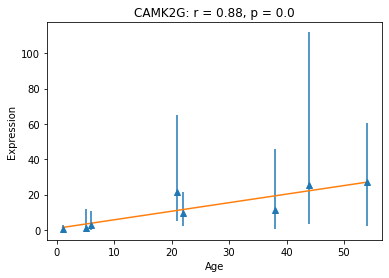

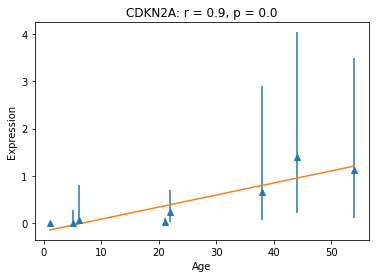

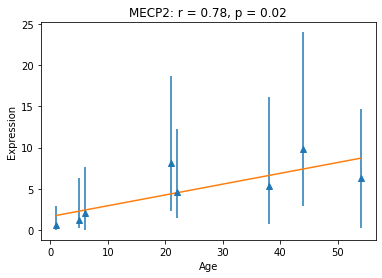

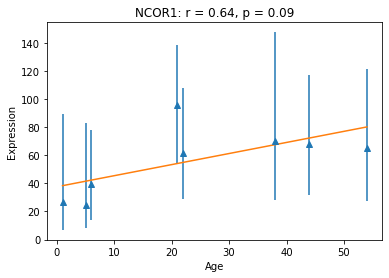

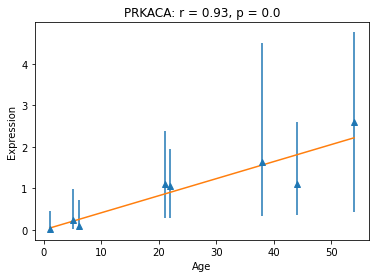

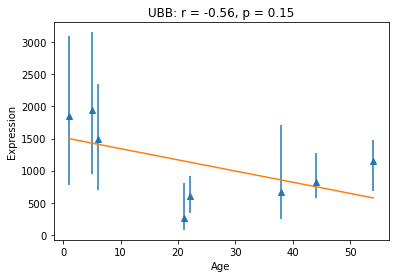

In [175]:
t = [int(i[:2]) for i in sorted(listdir(folder))]
that = np.linspace(min(t),max(t),1000)
for i,j in possibletargets.items():
    m = meds[:,gene2ind[i]]
    s = abs(m[:,np.newaxis] - iqrs[:,::-1,gene2ind[i]])
    
    (r, p) = sp.stats.pearsonr(t, m)
    poly = np.poly1d(np.polyfit(t, m, 1))
    mhat = poly(that)
    
    plt.errorbar(t, m, s.T, linestyle='None', marker='^')
    plt.plot(that,mhat)
    plt.title(f"{i}: r = {round(r,2)}, p = {round(p,2)}")
    plt.xlabel('Age')
    plt.ylabel('Expression')
    plt.show()

It seems like PRKACA would make the best target. With the intended targeting of Transcriptional Regulation by MECP2 and Regulation of MECP2 expression and activity. From here, you could look for known drugs that decrease PRKACA or you could base the drug search on the pathway analysis.

Unfortunately,
    (1) Has reletively constant expression accross cells from the same individual. Targeted cell delivery is a hard process, especially between cell types in the same organ, so the genes or pathways need to be consistant accross the single cells.
was not able to be achieved in any of the genes. This could because cells are naturally heterogeneous, the low dimentional space that biological expression data falls on is a manifold that may not be able to be expressed with PCA